In [ ]:
# train data
#!gdown --id 1IkkRN2GrP7E2_sE6HrCMjNfXuMfvFmgx
# new_train data
!gdown --id 1WqSZPhZ20aNu7CRQGDeIfabADFN7r8fz
# test data
!gdown --id 1n8abk_sHhuRskuAoj9g5ShfweRUS6S3U


In [ ]:
!tar xf mega_age_gender.tar.gz
!unzip small_data.zip
!rm -rf mega_age_gender.tar.gz
!rm -rf small_data.zip

# explore data

In [ ]:
import os 

root_dir = "mega_age_gender_sampling"
list_age = []
list_gender = []
list_path = []
for image_name in os.listdir(root_dir):
  age = ((image_name.split(".")[0]).split("_")[1]).split("A")[-1]
  gender = ((image_name.split(".")[0]).split("_")[2]).split("G")[-1]
  image_path = os.path.join(root_dir, image_name)
  
  list_age.append(int(age))
  list_gender.append(gender)
  list_path.append(image_path)

In [ ]:
from collections import Counter

Counter(list_gender)

Counter({'0': 5059, '1': 5132})

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go

In [ ]:
def plot_distribution(pd_series, name):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for {}'.format(name))
    
    fig.show()

bins = [0, 10, 20, 30, 40, 50, 60, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-50', '50-60', '60+']
age_series = pd.Series(list_age)
age_binned = pd.cut(age_series, bins, labels=names)
plot_distribution(age_binned, "age")

In [ ]:
# find max, min
MAX_AGE = max(list_age)
MIN_AGE = min(list_age)
print("max age: {}, min age: {}".format(MAX_AGE, MIN_AGE))
print("mean: ", sum(list_age)/len(list_age))

max age: 69, min age: 0
mean:  30.344715925816896


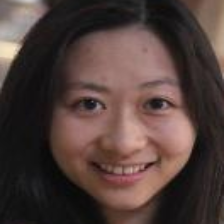

In [ ]:
from google.colab.patches import cv2_imshow
import cv2 

cv2_imshow(cv2.imread(list_path[0]))

# Datagenerator

In [ ]:
from sklearn.model_selection import train_test_split
import random
import cv2

In [ ]:
class AgeGenderDataGenerator(object):
  def __init__(self, min_age, max_age, list_path, input_size, batch_size=8):
    self.min_age = min_age
    self.max_age = max_age 
    self.list_path = list_path
    self.input_size = input_size
    self.batch_size = batch_size
    self.len_list_path = len(list_path)
  
  def split_data(self, ratio_test=0.2, ratio_val=0.2, shuffle=True):
    if shuffle:
      random.shuffle(self.list_path)

    test_index = int((1-ratio_test)*self.len_list_path)
    print("test_index: ", test_index)

    train_data = self.list_path[:test_index]
    test_data = self.list_path[test_index:]

    val_index = int((1-ratio_val)*len(train_data))
    print("val_index: ", val_index)

    subtrain_data = train_data[:val_index]
    val_data = train_data[val_index:]

    return subtrain_data, val_data, test_data 

  def preprocess_image(self, img_path):
      image = cv2.imread(img_path)
      image = cv2.resize(image, (self.input_size, self.input_size))
      image = image / 255.0
      
      return image
    
  def generate_images(self, list_paths, is_training):
        list_images, list_ages, list_genders = [], [], []
        while True:
            for image_path in list_paths:      
                age = float(((image_name.split(".")[0]).split("_")[1]).split("A")[-1])
                gender = int(((image_name.split(".")[0]).split("_")[2]).split("G")[-1])
                
                image = self.preprocess_image(image_path)
                
                list_ages.append(age / self.max_age)
                list_genders.append(gender)
                list_images.append(image)
                
                # yielding condition
                if len(list_images) >= self.batch_size:
                    yield np.array(list_images), [np.array(list_ages), np.array(list_genders)]
                    images, ages, races, genders = [], [], [], []
                    
            if not is_training:
                break    

In [ ]:
# INPUT_SIZE_LIST = {"b0": 224, "b1": 240, "b2": 260, "b3": 300, "b4": 380, "b5": 456, "b6": 528, "b7": 600}
data_generator = AgeGenderDataGenerator(MIN_AGE, MAX_AGE, list_path, 224, 8)

In [ ]:
train_data, val_data, test_data  = data_generator.split_data() 
print("len train: {}, len val: {}, len test: {}".format(len(train_data), len(val_data), len(test_data)))

test_index:  8152
val_index:  6521
len train: 6521, len val: 1631, len test: 2039


# Build model

In [ ]:
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, AveragePooling2D
import tensorflow as tf
import tensorflow.keras as keras 

In [ ]:
class AgeGenderModel(object):
  def __init__(self, width, height, depth, base_model="b0", first_layers_to_freeze=0):
    self.width = width
    self.height = height
    self.depth = depth
    self.base_model = base_model
    # b0: 20; b2: 33; b4: 147; b6: 45; b7: 265
    self.first_layers_to_freeze = first_layers_to_freeze
    self.input_shape = (width, height, depth)
  
  def build_BaseModel(self, inputs, name=""):
    if self.base_model == "b0":
      base_net = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")
    
    if self.first_layers_to_freeze == None:
      for layer in base_net.layers:
        layer._name = layer.name + str(name)
        layer.trainable = False
    else:
      for i, layer in enumerate(base_net.layers[:self.first_layers_to_freeze]):
        layer._name = layer.name + str(name)
        layer.trainable = False
      for i, layer in enumerate(base_net.layers[self.first_layers_to_freeze:]):
        layer._name = layer.name + str(name)
        layer.trainable = True
    
    return base_net
  
  def build_AgeBranch(self, inputs):
    base_net = self.build_BaseModel(inputs, "_age")
    headModel = base_net.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten_age")(headModel)
    headModel = Dense(1024, activation="relu")(headModel)
    headModel = Dropout(0.25)(headModel)
    headModel = Dense(1, activation="linear", name="age_output")(headModel)

    return headModel 
  
  def build_GenderBranch(self, inputs):
    base_net = self.build_BaseModel(inputs, "_gender")
    headModel = base_net.output
    headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
    headModel = Flatten(name="flatten_gender")(headModel)
    headModel = Dense(1024, activation="relu")(headModel)
    headModel = Dropout(0.25)(headModel)
    headModel = Dense(1, activation="sigmoid", name="gender_output")(headModel)

    return headModel
  
  def assemble_full_model(self):
    inputs = keras.Input(shape=self.input_shape)

    age_branch = self.build_AgeBranch(inputs)
    gender_branch = self.build_GenderBranch(inputs)

    model = Model(inputs=inputs,
                  outputs = [age_branch, gender_branch],
                  name="AgeGenderNet")
    
    return model

In [ ]:
age_gender_model = AgeGenderModel(224, 224, 3).assemble_full_model()

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(age_gender_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Training model

In [ ]:
# callback
output_model_path = "age_gender_model.h5"
mc = ModelCheckpoint(output_model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
init_lr = 1e-4
epochs = 2
opt = Adam(lr=init_lr, decay=init_lr / epochs)
age_gender_model.compile(optimizer=opt, 
              loss={
                  'age_output': 'mse', 
                  'gender_output': 'binary_crossentropy'},
              loss_weights={
                  'age_output': 2., 
                  'gender_output': 1.},
              metrics={
                  'age_output': 'mae', 
                  'gender_output': 'accuracy'})

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
train_gen = data_generator.generate_images(train_data, is_training=True)
valid_gen = data_generator.generate_images(val_data, is_training=True)

history = age_gender_model.fit_generator(train_gen,
                    steps_per_epoch=len(train_data)//8,
                    epochs=epochs,
                    callbacks=[mc],
                    validation_data=valid_gen,
                    validation_steps=len(val_data)//8)

# Trade plot

### gender acc

In [ ]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['gender_output_acc'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_gender_output_acc'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for gender feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

### Age Mean Absolute Error

In [ ]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['age_output_mean_absolute_error'],
                    name='Train'))
fig.add_trace(go.Scattergl(
                    y=history.history['val_age_output_mean_absolute_error'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Mean Absolute Error for age feature',
                  xaxis_title='Epoch',
                  yaxis_title='Mean Absolute Error')
fig.show()

### Overall loss

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(
                    y=history.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Overall loss',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()